In [73]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [74]:
df = pd.read_csv('rfm_xmas19.txt',parse_dates=['trans_date'])
df.head()

,customer_id,trans_date,tran_amount
0,FM5295,2017-11-11,35
1,FM4768,2019-12-15,39
2,FM2122,2017-11-26,52
3,FM1217,2016-08-16,99
4,FM1850,2018-08-20,78


In [75]:
df.duplicated().value_counts()

False    124993
True          7
dtype: int64

In [76]:
best_churn = pd.DataFrame(df.groupby(['customer_id'])['trans_date'].max())
best_churn.head()

,trans_date
customer_id,
FM1112,2019-10-14
FM1113,2019-11-09
FM1114,2019-11-12
FM1115,2019-12-05
FM1116,2019-05-25


In [77]:
cutoff_date = dt.datetime(2019,10,16)

best_churn['trans_date'].apply(lambda x: if 1 cutoff_date > x else 0)

In [78]:
best_churn['churned'] = best_churn['trans_date'].apply(lambda x: 1 if cutoff_date > x else 0)
best_churn.head()

,trans_date,churned
customer_id,,
FM1112,2019-10-14,1
FM1113,2019-11-09,0
FM1114,2019-11-12,0
FM1115,2019-12-05,0
FM1116,2019-05-25,1


In [79]:
best_churn['transactions'] = df.groupby('customer_id')['customer_id'].count()

In [80]:
best_churn['amount_spent'] = df.groupby('customer_id')['tran_amount'].sum()

In [81]:
best_churn.sample(3)

,trans_date,churned,transactions,amount_spent
customer_id,,,,
FM1771,2019-12-04,0,19,1337
FM1176,2019-11-15,0,18,1401
FM4059,2019-08-18,1,19,1274


In [117]:
best_churn.drop(['trans_date'],axis=1,inplace=True)

In [100]:
best_churn[['transactions','amount_spent']].describe().loc[['min','max']]

,transactions,amount_spent
min,4.0,149.0
max,39.0,2933.0


[Text(0, 0, 'Amount Spent')]

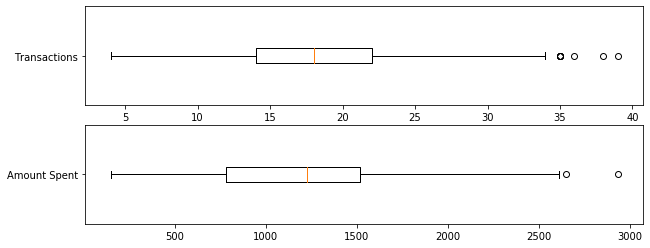

In [113]:

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,4))

ax1.boxplot(best_churn['transactions'],vert=False)
ax1.set_yticklabels(['Transactions'])
ax2.boxplot(best_churn['amount_spent'],vert=False)
ax2.set_yticklabels(['Amount Spent'])

In [104]:
best_churn['scale_transactions'] = best_churn['transactions'].apply(lambda x: (x - best_churn['transactions'].min())/(best_churn['transactions'].max() - best_churn['transactions'].min()) )

In [115]:
best_churn['scale_spent'] = best_churn['amount_spent'].apply(lambda x: (x - best_churn['amount_spent'].min())/(best_churn['amount_spent'].max() - best_churn['amount_spent'].min()))

In [118]:
best_churn.sample(2)

,churned,transactions,amount_spent,scale_transactions,scale_spent
customer_id,,,,,
FM5205,0,17,1185,0.371429,0.372126
FM2786,0,29,2034,0.714286,0.677083


In [125]:
best_churn[['scale_transactions','scale_spent']].apply(lambda x: 0.5 * x['scale_transactions'] + 0.5 * x['scale_spent'],axis=1)

customer_id
FM1112    0.312136
FM1113    0.469412
FM1114    0.444710
FM1115    0.528335
FM1116    0.255727
            ...   
FM8996    0.206337
FM8997    0.213619
FM8998    0.213880
FM8999    0.156312
FM9000    0.197537
Length: 6889, dtype: float64

In [86]:
# plt.subplot(1,2,1)
# plt.boxplot(best_churn['transactions'])

# plt.subplot(1,2,2)
# plt.boxplot(best_churn['amount_spent'])